# ATACseq

The methods for material handling and the wet lab parts of these molecular assays are detailed in previous publications [WHICH ONES?]. 

In  total, we have 6 stages in zebrafish: some, shield, 80% epiboly, 8 somites, 24hpf, 48hpf and four in amphixus: 8hpf, 15hpf, 36hpf, 60hpf.
After the material is sequences we obtain a .fq file, which contains the raw sequencing reads, a collection of about 49bp long sequences and their sequencing quality scores. To use these we must map them to a reference genome, converting each sequence to its absolute coordinates in the genome. We typically only keep reads that can only be mapped to a single position in the genome in order to avoid conflicts.


---
1. Fuentes, M. et al. Preliminary observations on the spawning conditions of the European amphioxus (Branchiostoma lanceolatum) in captivity. J Exp Zool B Mol Dev Evol 302, 384-391 (2004).
2. Fuentes, M. et al. Insights into spawning behavior and development of the European amphioxus (Branchiostoma lanceolatum). J Exp Zool B Mol Dev Evol 308, 484-493 (2007).



## Data processing
We used the following commands to map our .fq files

    # map to a temporary bam file
    >> bowtie2 -p 12 -x ${Genomeindex} -1 ${fqfile_1} -2 ${fqfile_2} \
          --dovetail -I 0 -X 1200 --very-sensitive  |  \
          samtools view -Shu - > ${temp_bam}

    >> samtools sort -@ 11 -T ${temp_bam} | \
            samtools rmdup -s - - > ${final_bam}
            
    >>samtools index ${final_bam
    

In comparison to the CHIPseq experiments, we need to do some preprocessing before looking for peaks. The most important difference is that we will filter reads by their fragment size and keep only those under a certain threshold. Since our data is pair-ended sequenced, we can deduce the fragment size of each of dna fragments that were sequenced, that's the distance between each two successive reads. Fragments over 146bp long are much more likely to originate from transposase events that happened on two sides of  a nucleosome. A nucleosome typically has 146bp wrapped around it, so but taking fragments under 146bp long, we make sure to enrich our signal in nucleosome free regions which are prime susspects for cis-regulatory elements.

To filter the reads, we used a home made script found in the Appendinx which we used like this:

    # We filter for under 120bp to be extra strict
    >> Thesis/scripts/get_nf_reads.py ${input_bam_file} 120 24 \
                                        "./results/chunk_{}.bed.gz"



As a result, we obtain the approved sequencing reads in a .bed file format which we can use to look for peaks.
We apply the idr method to detect peaks in ATACseq and take advantage of having replicates and a more appropriate type of signal (many shorter peaks).


The  analysis between this point and the final peaks file is a bit too long to include here so it can be found in the appendix :

    Appendices / Scripts / ATACseq IDR Peakcalling
    

Briefly, we apply the IDR method from [1] with no modifications.
See [2] for the code repository of their python package that we used.



---
1. "Measuring reproducibility of high-throughput experiments" (2011), Annals of Applied Statistics, Vol. 5, No. 3, 1752-1779, by Li, Brown, Huang, and Bickel
2. https://github.com/nboley/idr








<br><br><br><br><br><br><br>

In [1]:
load_NP = lambda fp: pd.read_csv( fp, sep='\t',header=None)

speciesorder = ['amphioxus','zebrafish','medaka','mouse']
amphioxus_stages = ['8','15','36','60']
zebrafish_stages = ['dome','shield','80epi','8som','24h','48h']
medaka_stages = ['dome','shield','8som','24h','48h']
mouse_stages = ['DE','ESC']

In [2]:
def get_widths(f, stage):
    df = load_NP(f(stage))
    return pd.DataFrame((df[2]-df[1]))
def get_masked_widths(f, stage,mask):
    df = load_NP(f(stage))
    ndf = (BT().
           from_dataframe( df.iloc[:,:3] )
           .subtract(mask, nonamecheck=True)
           .to_dataframe())
    return pd.DataFrame((ndf.end - ndf.start))
def get_masked_genome_coverage(f, stage,mask, effective):
    df = load_NP(f(stage))
    ndf = (BT().
           from_dataframe( df.iloc[:,:3] )
           .subtract(mask, nonamecheck=True)
           .to_dataframe())
    return (ndf.end-ndf.start).sum()*100 / effective
def get_numbers(f, stage):
    return len(load_NP(f(stage)))

In [3]:
# load the data for each species
amphi_ef = amphi_idr
zebra_ef = zebra_idr
mouse_ef = mouse_idr
medaka_ef = medaka_idr

amphi_lot = []
for st in amphioxus_stages:
    ldf = get_numbers(amphi_ef,st)
    amphi_lot.append([st, ldf])
amphi_tp = pd.DataFrame(amphi_lot)  

zebra_lot = []
for st in zebrafish_stages:
    ldf = get_numbers(zebra_ef,st)
    zebra_lot.append([st, ldf])
zebra_tp = pd.DataFrame(zebra_lot)

mouse_lot = []
for st in mouse_stages:
    ldf = get_numbers(mouse_ef,st)
    mouse_lot.append([st, ldf])
mouse_tp = pd.DataFrame(mouse_lot)

medaka_lot = []
for st in medaka_stages:
    ldf = get_numbers(medaka_ef,st)
    medaka_lot.append([st, ldf])
medaka_tp = pd.DataFrame(medaka_lot)

In [4]:
#the _tp dataframes look like this:
amphi_tp.head(2)

0      1
0   8  25455
1  15  47002

In [5]:
# divide by 1000 just to make the y axis labels on the plot smaller
amphi_tpc = amphi_tp.copy()
amphi_tpc[1] = amphi_tpc[1]/1000
zebra_tpc = zebra_tp.copy()
zebra_tpc[1] = zebra_tpc[1]/1000
mouse_tpc = mouse_tp.copy()
mouse_tpc[1] = mouse_tpc[1]/1000
medaka_tpc = medaka_tp.copy()
medaka_tpc[1] = medaka_tpc[1]/1000

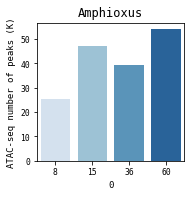

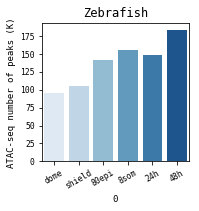

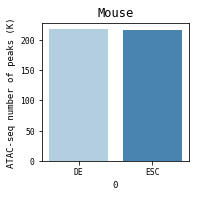

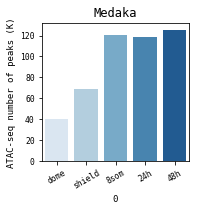

In [6]:
Fwidth = THESIS_PAGEWIDTH/2
Fheight = THESIS_PAGEWIDTH/2

fig, ax = plt.subplots(1, 1)
fig.subplots_adjust(left=.19, bottom=.15, right=.99, top=.9)
sns.barplot(data=amphi_tpc, x=0,y=1, ax=ax, palette='Blues',order=['8','15','36','60'] )
# ax.set_xlabel('amphioxus (dev stages)')
ax.set_ylabel('ATAC-seq number of peaks (K)')
fig.set_size_inches(Fwidth, Fheight)
plt.title('Amphioxus')
fig.savefig('../Figures/from_notebooks/tfigure_amphiK4peaks_0.pdf')

fig, ax = plt.subplots(1, 1)
fig.subplots_adjust(left=.19, bottom=.15, right=.99, top=.9)
sns.barplot(data=zebra_tpc, x=0,y=1, ax=ax, palette='Blues', )
# ax.set_xlabel('zebrfish (dev stages)')
ax.set_ylabel('ATAC-seq number of peaks (K)')
plt.xticks(rotation=30)
fig.set_size_inches(Fwidth, Fheight)
plt.title('Zebrafish')
fig.savefig('../Figures/from_notebooks/tfigure_amphiK4peaks_1.pdf')

fig, ax = plt.subplots(1, 1)
fig.subplots_adjust(left=.19, bottom=.15, right=.99, top=.9)
sns.barplot(data=mouse_tpc, x=0,y=1, ax=ax, palette='Blues', )
# ax.set_xlabel('mouse (dev stages)')
ax.set_ylabel('ATAC-seq number of peaks (K)')
fig.set_size_inches(Fwidth, Fheight)
plt.title('Mouse')
fig.savefig('../Figures/from_notebooks/tfigure_amphiK4peaks_2.pdf')

fig, ax = plt.subplots(1, 1)
fig.subplots_adjust(left=.19, bottom=.15, right=.99, top=.9)
sns.barplot(data=medaka_tpc, x=0,y=1, ax=ax, palette='Blues', )
# ax.set_xlabel('medaka (dev stages)')
ax.set_ylabel('ATAC-seq number of peaks (K)')
plt.xticks(rotation=30)
fig.set_size_inches(Fwidth, Fheight)
plt.title('Medaka')
fig.savefig('../Figures/from_notebooks/tfigure_amphiK4peaks_3.pdf')